# Restaurant Rating Prediction (1–5) — EDA + 3 Skenario **Baru** (Per Model)
Notebook ini menyajikan **alur skenario yang benar-benar berbeda secara perlakuan**, sehingga S1 vs S2 vs S3
tidak terasa sama.

## Definisi Skenario
### Skenario 1 — Baseline fine-grained **tanpa** penanganan imbalance
- Target rating 1–5.
- Train original (imbalanced).
- 5 model: SVM, NB, LSTM, BERT, RoBERTa.

### Skenario 2 — Penanganan imbalance **tanpa augmentasi teks**
- Target rating 1–5.
- **Teks tidak diubah**.
- Teknik balancing non-semantic:
  - SVM: `class_weight='balanced'`
  - NB: **duplicate oversampling** (duplikasi sampel)
  - LSTM: **weighted loss**
  - BERT/RoBERTa: **weighted loss** via `WeightedTrainer`

### Skenario 3 — Penanganan imbalance **dengan augmentasi teks**
- Target rating 1–5.
- Augment kelas minoritas pada train.
- Strategi: EDA, Modified EDA (opsional: Backtranslation, BERT augmentation).
- 5 model dilatih ulang.

## Catatan CPU
BERT/RoBERTa tetap aktif. Jika tanpa GPU, konfigurasi dibuat ringan
(batch kecil, max_length lebih pendek, opsional shrink train).


## 0. Setup & Library

In [1]:

# !pip -q install pandas numpy scikit-learn matplotlib nltk tqdm
# !pip -q install torch transformers datasets evaluate accelerate
# !pip -q install nlpaug

import os, re, glob, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.utils.class_weight import compute_class_weight

import torch

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

HAS_GPU = torch.cuda.is_available()
DEVICE = "cuda" if HAS_GPU else "cpu"
print("Device:", DEVICE)


Device: cpu


## 1. Load Dataset

In [2]:

DATA_PATH = "dataset/reviews.csv"  # <-- ganti sesuai file Anda

if not os.path.exists(DATA_PATH):
    candidates = glob.glob("**/*.csv", recursive=True)
    preferred = [c for c in candidates if re.search(r"(review|google|maps|restaurant)", c, re.I)]
    if preferred:
        DATA_PATH = preferred[0]
    elif candidates:
        DATA_PATH = candidates[0]

print("Using DATA_PATH:", DATA_PATH)

df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
df.head()


Using DATA_PATH: dataset/reviews.csv
Shape: (1100, 6)


,business_name,author_name,text,photo,rating,rating_category
0,Haci'nin Yeri - Yigit Lokantasi,Gulsum Akar,We went to Marmaris with my wife for a holiday...,dataset/taste/hacinin_yeri_gulsum_akar.png,5,taste
1,Haci'nin Yeri - Yigit Lokantasi,Oguzhan Cetin,During my holiday in Marmaris we ate here to f...,dataset/menu/hacinin_yeri_oguzhan_cetin.png,4,menu
2,Haci'nin Yeri - Yigit Lokantasi,Yasin Kuyu,Prices are very affordable. The menu in the ph...,dataset/outdoor_atmosphere/hacinin_yeri_yasin_...,3,outdoor_atmosphere
3,Haci'nin Yeri - Yigit Lokantasi,Orhan Kapu,Turkey's cheapest artisan restaurant and its f...,dataset/indoor_atmosphere/hacinin_yeri_orhan_k...,5,indoor_atmosphere
4,Haci'nin Yeri - Yigit Lokantasi,Ozgur Sati,I don't know what you will look for in terms o...,dataset/menu/hacinin_yeri_ozgur_sati.png,3,menu


## 2. Cleaning & Text Preprocessing (Lemmatization)

Preprocessing:
- normalisasi spasi
- lowercasing
- pembersihan karakter non-alfabet sederhana
- tokenisasi
- **lemmatization** WordNet dengan POS tagger.

Blok download NLTK dibuat robust untuk versi lama/baru.


In [3]:

import nltk

resources = [
    ("tokenizers/punkt", "punkt"),
    ("taggers/averaged_perceptron_tagger", "averaged_perceptron_tagger"),
    ("taggers/averaged_perceptron_tagger_eng", "averaged_perceptron_tagger_eng"),
    ("corpora/wordnet", "wordnet"),
    ("corpora/omw-1.4", "omw-1.4"),
]

for path, name in resources:
    try:
        nltk.data.find(path)
    except LookupError:
        nltk.download(name)

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

lemmatizer = WordNetLemmatizer()

def penn_to_wn(tag):
    if tag.startswith("J"): return wordnet.ADJ
    if tag.startswith("V"): return wordnet.VERB
    if tag.startswith("N"): return wordnet.NOUN
    if tag.startswith("R"): return wordnet.ADV
    return wordnet.NOUN

def basic_normalize(text: str) -> str:
    text = str(text).strip()
    text = re.sub(r"\s+", " ", text)
    return text

def clean_for_lemma(text: str) -> str:
    text = text.lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def lemmatize_text(text: str) -> str:
    text = clean_for_lemma(basic_normalize(text))
    if not text:
        return ""
    toks = word_tokenize(text)
    pos_tags = nltk.pos_tag(toks)
    lemmas = [lemmatizer.lemmatize(w, penn_to_wn(t)) for w, t in pos_tags]
    return " ".join(lemmas)

assert "text" in df.columns, "Kolom 'text' tidak ditemukan."
assert "rating" in df.columns, "Kolom 'rating' tidak ditemukan."

df = df.dropna(subset=["text", "rating"]).copy()
df["rating"] = df["rating"].astype(int)
df = df[df["rating"].between(1, 5)]

df["text_basic"] = df["text"].apply(basic_normalize)
df["text_lemma"] = df["text"].apply(lemmatize_text)
df["text_clean"] = df["text_lemma"]

print("After cleaning:", df.shape)
df.head()


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


After cleaning: (1100, 9)


,business_name,author_name,text,photo,rating,rating_category,text_basic,text_lemma,text_clean
0,Haci'nin Yeri - Yigit Lokantasi,Gulsum Akar,We went to Marmaris with my wife for a holiday...,dataset/taste/hacinin_yeri_gulsum_akar.png,5,taste,We went to Marmaris with my wife for a holiday...,we go to marmaris with my wife for a holiday w...,we go to marmaris with my wife for a holiday w...
1,Haci'nin Yeri - Yigit Lokantasi,Oguzhan Cetin,During my holiday in Marmaris we ate here to f...,dataset/menu/hacinin_yeri_oguzhan_cetin.png,4,menu,During my holiday in Marmaris we ate here to f...,during my holiday in marmaris we eat here to f...,during my holiday in marmaris we eat here to f...
2,Haci'nin Yeri - Yigit Lokantasi,Yasin Kuyu,Prices are very affordable. The menu in the ph...,dataset/outdoor_atmosphere/hacinin_yeri_yasin_...,3,outdoor_atmosphere,Prices are very affordable. The menu in the ph...,price be very affordable the menu in the photo...,price be very affordable the menu in the photo...
3,Haci'nin Yeri - Yigit Lokantasi,Orhan Kapu,Turkey's cheapest artisan restaurant and its f...,dataset/indoor_atmosphere/hacinin_yeri_orhan_k...,5,indoor_atmosphere,Turkey's cheapest artisan restaurant and its f...,turkey s cheap artisan restaurant and it food ...,turkey s cheap artisan restaurant and it food ...
4,Haci'nin Yeri - Yigit Lokantasi,Ozgur Sati,I don't know what you will look for in terms o...,dataset/menu/hacinin_yeri_ozgur_sati.png,3,menu,I don't know what you will look for in terms o...,i don t know what you will look for in term of...,i don t know what you will look for in term of...


## 3. Exploratory Data Analysis (EDA)

In [4]:

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   business_name    1100 non-null   object
 1   author_name      1100 non-null   object
 2   text             1100 non-null   object
 3   photo            1100 non-null   object
 4   rating           1100 non-null   int64 
 5   rating_category  1100 non-null   object
 6   text_basic       1100 non-null   object
 7   text_lemma       1100 non-null   object
 8   text_clean       1100 non-null   object
dtypes: int64(1), object(8)
memory usage: 77.5+ KB


In [5]:

rating_counts = df["rating"].value_counts().sort_index()
rating_counts


rating
1     80
2     72
3    172
4    316
5    460
Name: count, dtype: int64

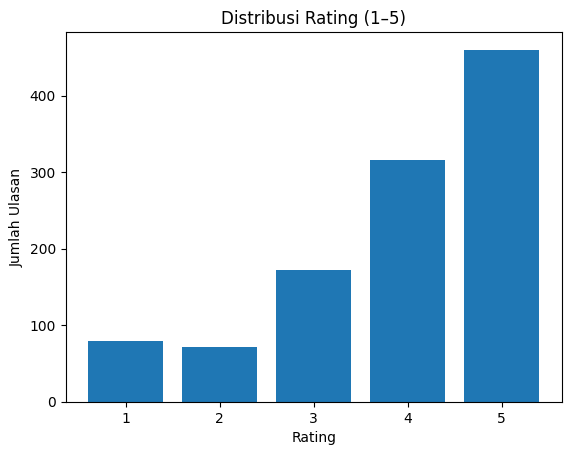

In [6]:

plt.figure()
plt.bar(rating_counts.index.astype(str), rating_counts.values)
plt.title("Distribusi Rating (1–5)")
plt.xlabel("Rating")
plt.ylabel("Jumlah Ulasan")
plt.show()


In [7]:

df["char_len"] = df["text_basic"].str.len()
df["word_len"] = df["text_basic"].str.split().apply(len)

df[["char_len", "word_len"]].describe()


,char_len,word_len
count,1100.000000,1100.000000
mean,110.827273,20.051818
std,69.144698,12.977619
min,5.000000,1.000000
25%,62.000000,11.000000
50%,104.000000,19.000000
75%,147.000000,27.000000
max,914.000000,179.000000


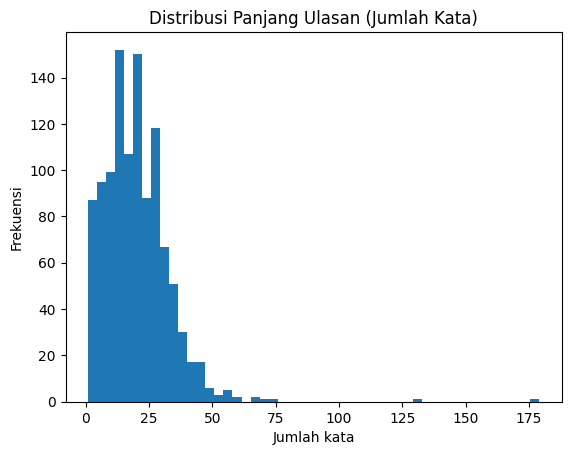

In [8]:

plt.figure()
plt.hist(df["word_len"], bins=50)
plt.title("Distribusi Panjang Ulasan (Jumlah Kata)")
plt.xlabel("Jumlah kata")
plt.ylabel("Frekuensi")
plt.show()


## 4. Train/Test Split (Konsisten)

In [9]:

X = df["text_clean"].values
y = df["rating"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=SEED,
    stratify=y
)

print("Train:", len(X_train), "Test:", len(X_test))
print("Distribusi Train:", Counter(y_train))
print("Distribusi Test :", Counter(y_test))


Train: 880 Test: 220
Distribusi Train: Counter({np.int64(5): 368, np.int64(4): 253, np.int64(3): 137, np.int64(1): 64, np.int64(2): 58})
Distribusi Test : Counter({np.int64(5): 92, np.int64(4): 63, np.int64(3): 35, np.int64(1): 16, np.int64(2): 14})


## 5. Utilitas Evaluasi

In [10]:

def eval_report(y_true, y_pred, title="Model"):
    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average="macro")
    f1w = f1_score(y_true, y_pred, average="weighted")

    print(f"=== {title} ===")
    print("Accuracy :", round(acc, 4))
    print("F1-macro :", round(f1m, 4))
    print("F1-weight:", round(f1w, 4))
    print()
    print(classification_report(y_true, y_pred, digits=4, zero_division=0))
    print()
    return {"model": title, "accuracy": acc, "f1_macro": f1m, "f1_weighted": f1w}

def plot_confusion(y_true, y_pred, labels=range(1, 6), title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred, labels=list(labels))
    plt.figure()
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels)
    plt.yticks(tick_marks, labels)
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.tight_layout()
    plt.show()


## 6. Helper Model Klasik (TF–IDF)

In [11]:

def fit_tfidf(train_texts, test_texts):
    vec = TfidfVectorizer(lowercase=True, max_features=50000, ngram_range=(1, 2))
    Xtr = vec.fit_transform(train_texts)
    Xte = vec.transform(test_texts)
    return vec, Xtr, Xte

def train_eval_svm(train_texts, train_labels, test_texts, test_labels, suffix="", class_weight=None):
    vec, Xtr, Xte = fit_tfidf(train_texts, test_texts)
    svm = LinearSVC(class_weight=class_weight)
    svm.fit(Xtr, train_labels)
    pred = svm.predict(Xte)
    res = eval_report(test_labels, pred, f"Linear SVM{suffix}")
    return res, vec, svm, pred

def train_eval_nb(train_texts, train_labels, test_texts, test_labels, suffix=""):
    vec, Xtr, Xte = fit_tfidf(train_texts, test_texts)
    nb = MultinomialNB()
    nb.fit(Xtr, train_labels)
    pred = nb.predict(Xte)
    res = eval_report(test_labels, pred, f"Naive Bayes{suffix}")
    return res, vec, nb, pred


## 7. Duplicate Oversampling (Non-Aug, untuk S2)

In [12]:

def duplicate_oversample(texts, labels):
    texts, labels = list(texts), list(labels)
    counts = Counter(labels)
    max_count = max(counts.values())

    idx_by = {c: [] for c in counts}
    for i, y in enumerate(labels):
        idx_by[y].append(i)

    new_texts, new_labels = texts[:], labels[:]

    for c, idxs in idx_by.items():
        need = max_count - counts[c]
        if need <= 0:
            continue
        for _ in range(need):
            i = random.choice(idxs)
            new_texts.append(texts[i])   # teks sama persis
            new_labels.append(c)

    return np.array(new_texts), np.array(new_labels)

print("Train original:", Counter(y_train))
Xt_dup, yt_dup = duplicate_oversample(X_train, y_train)
print("Train after duplicate oversampling:", Counter(yt_dup))


Train original: Counter({np.int64(5): 368, np.int64(4): 253, np.int64(3): 137, np.int64(1): 64, np.int64(2): 58})
Train after duplicate oversampling: Counter({np.int64(4): 368, np.int64(5): 368, np.int64(2): 368, np.int64(3): 368, np.int64(1): 368})


## 8. Helper LSTM (PyTorch)

In [13]:

import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

def build_vocab(texts, max_vocab=30000, min_freq=2):
    from collections import Counter as CCounter
    counter = CCounter()
    for t in texts:
        counter.update(str(t).split())
    vocab = {"<pad>": 0, "<unk>": 1}
    for w, c in counter.most_common():
        if c < min_freq:
            continue
        if len(vocab) >= max_vocab:
            break
        vocab[w] = len(vocab)
    return vocab

def encode(text, vocab, max_len=200):
    tokens = str(text).split()
    ids = [vocab.get(t, vocab["<unk>"]) for t in tokens[:max_len]]
    if len(ids) < max_len:
        ids += [vocab["<pad>"]] * (max_len - len(ids))
    return ids

class TextDataset(Dataset):
    def __init__(self, texts, labels, vocab, max_len=200):
        self.texts = list(texts)
        self.labels = list(labels)
        self.vocab = vocab
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        x = torch.tensor(encode(self.texts[idx], self.vocab, self.max_len), dtype=torch.long)
        y = torch.tensor(int(self.labels[idx]) - 1, dtype=torch.long)  # 1-5 -> 0-4
        return x, y

class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim=128, hidden_dim=128, num_classes=5):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.lstm = nn.LSTM(emb_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, x):
        emb = self.embedding(x)
        out, _ = self.lstm(emb)
        last = out[:, -1, :]
        last = self.dropout(last)
        return self.fc(last)

def train_eval_lstm(
    train_texts, train_labels, test_texts, test_labels,
    epochs=3, max_len=200, batch_size=64, suffix="",
    use_class_weights=False
):
    vocab = build_vocab(train_texts)
    train_ds = TextDataset(train_texts, train_labels, vocab, max_len)
    test_ds  = TextDataset(test_texts, test_labels, vocab, max_len)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

    model = LSTMClassifier(len(vocab)).to(DEVICE)

    if use_class_weights:
        classes = np.array([1,2,3,4,5])
        cw = compute_class_weight(class_weight="balanced", classes=classes, y=np.array(train_labels))
        class_weights = torch.tensor(cw, dtype=torch.float).to(DEVICE)
        criterion = nn.CrossEntropyLoss(weight=class_weights)
    else:
        criterion = nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    def train_one_epoch():
        model.train()
        total = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()
            total += float(loss.item())
        return total / max(1, len(train_loader))

    def predict():
        model.eval()
        preds, trues = [], []
        with torch.no_grad():
            for xb, yb in test_loader:
                xb = xb.to(DEVICE)
                logits = model(xb)
                p = torch.argmax(logits, dim=1).cpu().numpy()
                preds.extend(list(p))
                trues.extend(list(yb.numpy()))
        preds = np.array(preds) + 1
        trues = np.array(trues) + 1
        return trues, preds

    for ep in range(epochs):
        loss = train_one_epoch()
        print(f"[LSTM{suffix}] Epoch {ep+1}/{epochs} | loss={loss:.4f}")

    yt, yp = predict()
    return eval_report(yt, yp, f"LSTM{suffix}")


## 9. Helper Transformer (BERT & RoBERTa) — WeightedTrainer + Output Seragam

In [14]:
from datasets import Dataset
import evaluate
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

DEFAULT_MAX_LEN = 256 if HAS_GPU else 128
DEFAULT_BATCH = 8 if HAS_GPU else 2
DEFAULT_EPOCHS = 1

USE_SMALL_TRAIN_IF_CPU = True
SMALL_TRAIN_N = 2000

def make_hf_dataset(texts, labels):
    return Dataset.from_dict({"text": list(texts), "label": [int(l) - 1 for l in labels]})

def make_tokenize_fn(tokenizer, max_length):
    def _tok(batch):
        return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=max_length)
    return _tok

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_metric.compute(predictions=preds, references=labels)["accuracy"]
    f1m = f1_metric.compute(predictions=preds, references=labels, average="macro")["f1"]
    f1w = f1_metric.compute(predictions=preds, references=labels, average="weighted")["f1"]
    return {"accuracy": acc, "f1_macro": f1m, "f1_weighted": f1w}

def maybe_shrink_train(train_texts, train_labels):
    if (not HAS_GPU) and USE_SMALL_TRAIN_IF_CPU and len(train_texts) > SMALL_TRAIN_N:
        return train_texts[:SMALL_TRAIN_N], train_labels[:SMALL_TRAIN_N]
    return train_texts, train_labels

def build_training_args(out_dir, epochs, batch_size):
    common = dict(
        output_dir=out_dir,
        save_strategy="no",
        learning_rate=2e-5,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=epochs,
        weight_decay=0.01,
        logging_steps=50,
        report_to="none",
        seed=SEED,
        fp16=HAS_GPU,
        dataloader_num_workers=0,
    )
    try:
        return TrainingArguments(**common, evaluation_strategy="epoch")
    except TypeError:
        return TrainingArguments(**common, eval_strategy="epoch")

class WeightedTrainer(Trainer):
    def __init__(self, class_weights=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    # NOTE: Transformers versi baru meneruskan argumen tambahan seperti
    # num_items_in_batch ke compute_loss. Kita terima via **kwargs agar kompatibel.
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        inputs = dict(inputs)
        labels = inputs.get("labels")

        outputs = model(**inputs)
        logits = outputs.get("logits")

        if self.class_weights is not None:
            cw = self.class_weights.to(logits.device)
            loss_fct = torch.nn.CrossEntropyLoss(weight=cw)
        else:
            loss_fct = torch.nn.CrossEntropyLoss()

        loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

def _build_trainer(model, args, train_tok, test_tok, tokenizer, use_class_weights, class_weights):
    base_kwargs = dict(
        model=model,
        args=args,
        train_dataset=train_tok,
        eval_dataset=test_tok,
        compute_metrics=compute_metrics,
    )

    if use_class_weights:
        cls = WeightedTrainer
        base_kwargs["class_weights"] = class_weights
    else:
        cls = Trainer

    # Kompatibilitas argumen tokenizer -> processing_class
    try:
        return cls(**base_kwargs, tokenizer=tokenizer)
    except TypeError:
        return cls(**base_kwargs, processing_class=tokenizer)

def train_eval_transformer(
    model_name,
    train_texts, train_labels,
    test_texts, test_labels,
    epochs=DEFAULT_EPOCHS, batch_size=DEFAULT_BATCH,
    max_length=DEFAULT_MAX_LEN, out_dir="./tmp_tr", suffix="",
    use_class_weights=False
):
    train_texts2, train_labels2 = maybe_shrink_train(train_texts, train_labels)

    train_hf = make_hf_dataset(train_texts2, train_labels2)
    test_hf  = make_hf_dataset(test_texts, test_labels)

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5)

    tok_fn = make_tokenize_fn(tokenizer, max_length=max_length)
    train_tok = train_hf.map(tok_fn, batched=True)
    test_tok  = test_hf.map(tok_fn, batched=True)

    # rename label column to labels for custom loss safety
    train_tok = train_tok.remove_columns(["text"]).rename_column("label", "labels")
    test_tok  = test_tok.remove_columns(["text"]).rename_column("label", "labels")

    args = build_training_args(out_dir, epochs, batch_size)

    class_weights = None
    if use_class_weights:
        classes = np.array([1,2,3,4,5])
        cw = compute_class_weight(class_weight="balanced", classes=classes, y=np.array(train_labels2))
        class_weights = torch.tensor(cw, dtype=torch.float)

    trainer = _build_trainer(
        model=model,
        args=args,
        train_tok=train_tok,
        test_tok=test_tok,
        tokenizer=tokenizer,
        use_class_weights=use_class_weights,
        class_weights=class_weights
    )

    trainer.train()
    res = trainer.evaluate()

    out = {
        "model": model_name + suffix,
        "accuracy": res.get("eval_accuracy"),
        "f1_macro": res.get("eval_f1_macro"),
        "f1_weighted": res.get("eval_f1_weighted"),
        "eval_loss": res.get("eval_loss"),
        "eval_runtime": res.get("eval_runtime"),
        "eval_samples_per_second": res.get("eval_samples_per_second"),
        "eval_steps_per_second": res.get("eval_steps_per_second"),
        "epoch": res.get("epoch"),
    }

    print(f"=== {model_name}{suffix} ===")
    print(res)
    print()
    return out

## 10. Skenario 1 — Baseline (5 Model, No Handling)

### 10.1 Linear SVM (S1)

In [15]:

results_s1 = []

svm_s1_res, _, _, svm_s1_pred = train_eval_svm(
    X_train, y_train, X_test, y_test,
    suffix=" (S1 baseline)",
    class_weight=None
)
results_s1.append(svm_s1_res)


=== Linear SVM (S1 baseline) ===
Accuracy : 0.5
F1-macro : 0.3758
F1-weight: 0.4734

              precision    recall  f1-score   support

           1     0.5556    0.3125    0.4000        16
           2     0.3333    0.0714    0.1176        14
           3     0.3571    0.2857    0.3175        35
           4     0.3966    0.3651    0.3802        63
           5     0.5820    0.7717    0.6636        92

    accuracy                         0.5000       220
   macro avg     0.4449    0.3613    0.3758       220
weighted avg     0.4754    0.5000    0.4734       220




### 10.2 Naive Bayes (S1)

In [16]:

nb_s1_res, _, _, _ = train_eval_nb(
    X_train, y_train, X_test, y_test,
    suffix=" (S1 baseline)"
)
results_s1.append(nb_s1_res)


=== Naive Bayes (S1 baseline) ===
Accuracy : 0.4364
F1-macro : 0.1479
F1-weight: 0.2912

              precision    recall  f1-score   support

           1     0.0000    0.0000    0.0000        16
           2     0.0000    0.0000    0.0000        14
           3     0.0000    0.0000    0.0000        35
           4     0.5000    0.0794    0.1370        63
           5     0.4333    0.9891    0.6026        92

    accuracy                         0.4364       220
   macro avg     0.1867    0.2137    0.1479       220
weighted avg     0.3244    0.4364    0.2912       220




### 10.3 LSTM (S1)

In [17]:

try:
    lstm_s1_res = train_eval_lstm(
        X_train, y_train, X_test, y_test,
        epochs=3, suffix=" (S1 baseline)",
        use_class_weights=False
    )
    results_s1.append(lstm_s1_res)
except Exception as e:
    print("LSTM S1 error:", e)


[LSTM (S1 baseline)] Epoch 1/3 | loss=1.5551
[LSTM (S1 baseline)] Epoch 2/3 | loss=1.4000
[LSTM (S1 baseline)] Epoch 3/3 | loss=1.3936
=== LSTM (S1 baseline) ===
Accuracy : 0.4182
F1-macro : 0.1179
F1-weight: 0.2466

              precision    recall  f1-score   support

           1     0.0000    0.0000    0.0000        16
           2     0.0000    0.0000    0.0000        14
           3     0.0000    0.0000    0.0000        35
           4     0.0000    0.0000    0.0000        63
           5     0.4182    1.0000    0.5897        92

    accuracy                         0.4182       220
   macro avg     0.0836    0.2000    0.1179       220
weighted avg     0.1749    0.4182    0.2466       220




### 10.4 BERT (S1)

In [18]:

try:
    bert_s1_res = train_eval_transformer(
        "bert-base-uncased",
        X_train, y_train, X_test, y_test,
        epochs=DEFAULT_EPOCHS,
        batch_size=DEFAULT_BATCH,
        max_length=DEFAULT_MAX_LEN,
        out_dir="./tmp_bert_s1",
        suffix=" (S1 baseline)",
        use_class_weights=False
    )
    results_s1.append(bert_s1_res)
except Exception as e:
    print("BERT S1 error:", e)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/880 [00:00<?, ? examples/s]

Map:   0%|          | 0/220 [00:00<?, ? examples/s]

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_24684\2636105220.py:96: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  return cls(**base_kwargs, tokenizer=tokenizer)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,1.179300,1.147911,0.486364,0.210667,0.400061


c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


=== bert-base-uncased (S1 baseline) ===
{'eval_loss': 1.1479114294052124, 'eval_accuracy': 0.4863636363636364, 'eval_f1_macro': 0.21066666666666664, 'eval_f1_weighted': 0.4000606060606061, 'eval_runtime': 40.4475, 'eval_samples_per_second': 5.439, 'eval_steps_per_second': 2.72, 'epoch': 1.0}



### 10.5 RoBERTa (S1)

In [19]:

try:
    roberta_s1_res = train_eval_transformer(
        "roberta-base",
        X_train, y_train, X_test, y_test,
        epochs=DEFAULT_EPOCHS,
        batch_size=DEFAULT_BATCH,
        max_length=DEFAULT_MAX_LEN,
        out_dir="./tmp_roberta_s1",
        suffix=" (S1 baseline)",
        use_class_weights=False
    )
    results_s1.append(roberta_s1_res)
except Exception as e:
    print("RoBERTa S1 error:", e)

s1_table = pd.DataFrame(results_s1)
s1_table.sort_values("f1_macro", ascending=False)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/880 [00:00<?, ? examples/s]

Map:   0%|          | 0/220 [00:00<?, ? examples/s]

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_24684\2636105220.py:96: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  return cls(**base_kwargs, tokenizer=tokenizer)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,1.220700,1.171993,0.490909,0.208292,0.396256


c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


=== roberta-base (S1 baseline) ===
{'eval_loss': 1.1719926595687866, 'eval_accuracy': 0.4909090909090909, 'eval_f1_macro': 0.2082924168030551, 'eval_f1_weighted': 0.3962555175321133, 'eval_runtime': 24.1666, 'eval_samples_per_second': 9.103, 'eval_steps_per_second': 4.552, 'epoch': 1.0}



,model,accuracy,f1_macro,f1_weighted,eval_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch
0,Linear SVM (S1 baseline),0.500000,0.375765,0.473433,NaN,NaN,NaN,NaN,NaN
3,bert-base-uncased (S1 baseline),0.486364,0.210667,0.400061,1.147911,40.4475,5.439,2.720,1.0
4,roberta-base (S1 baseline),0.490909,0.208292,0.396256,1.171993,24.1666,9.103,4.552,1.0
1,Naive Bayes (S1 baseline),0.436364,0.147927,0.291245,NaN,NaN,NaN,NaN,NaN
2,LSTM (S1 baseline),0.418182,0.117949,0.246620,NaN,NaN,NaN,NaN,NaN


## 11. Skenario 2 — Balancing **Tanpa** Augmentasi Teks (5 Model)

### 11.1 Linear SVM (S2 — class_weight balanced)

In [20]:

results_s2 = []

svm_s2_res, _, _, _ = train_eval_svm(
    X_train, y_train, X_test, y_test,
    suffix=" (S2 balanced no-aug)",
    class_weight="balanced"
)
results_s2.append(svm_s2_res)


=== Linear SVM (S2 balanced no-aug) ===
Accuracy : 0.4909
F1-macro : 0.384
F1-weight: 0.4769

              precision    recall  f1-score   support

           1     0.4545    0.3125    0.3704        16
           2     0.2500    0.1429    0.1818        14
           3     0.3333    0.3429    0.3380        35
           4     0.3684    0.3333    0.3500        63
           5     0.6296    0.7391    0.6800        92

    accuracy                         0.4909       220
   macro avg     0.4072    0.3741    0.3840       220
weighted avg     0.4708    0.4909    0.4769       220




### 11.2 Naive Bayes (S2 — duplicate oversampling)

In [21]:

Xt_dup, yt_dup = duplicate_oversample(X_train, y_train)

nb_s2_res, _, _, _ = train_eval_nb(
    Xt_dup, yt_dup, X_test, y_test,
    suffix=" (S2 balanced no-aug)"
)
results_s2.append(nb_s2_res)


=== Naive Bayes (S2 balanced no-aug) ===
Accuracy : 0.4227
F1-macro : 0.3703
F1-weight: 0.444

              precision    recall  f1-score   support

           1     0.3529    0.3750    0.3636        16
           2     0.1395    0.4286    0.2105        14
           3     0.3023    0.3714    0.3333        35
           4     0.3913    0.2857    0.3303        63
           5     0.7042    0.5435    0.6135        92

    accuracy                         0.4227       220
   macro avg     0.3781    0.4008    0.3703       220
weighted avg     0.4892    0.4227    0.4440       220




### 11.3 LSTM (S2 — weighted loss)

In [22]:

try:
    lstm_s2_res = train_eval_lstm(
        X_train, y_train, X_test, y_test,
        epochs=3, suffix=" (S2 balanced no-aug)",
        use_class_weights=True
    )
    results_s2.append(lstm_s2_res)
except Exception as e:
    print("LSTM S2 error:", e)


[LSTM (S2 balanced no-aug)] Epoch 1/3 | loss=1.6113
[LSTM (S2 balanced no-aug)] Epoch 2/3 | loss=1.6106
[LSTM (S2 balanced no-aug)] Epoch 3/3 | loss=1.6103
=== LSTM (S2 balanced no-aug) ===
Accuracy : 0.2864
F1-macro : 0.089
F1-weight: 0.1275

              precision    recall  f1-score   support

           1     0.0000    0.0000    0.0000        16
           2     0.0000    0.0000    0.0000        14
           3     0.0000    0.0000    0.0000        35
           4     0.2864    1.0000    0.4452        63
           5     0.0000    0.0000    0.0000        92

    accuracy                         0.2864       220
   macro avg     0.0573    0.2000    0.0890       220
weighted avg     0.0820    0.2864    0.1275       220




### 11.4 BERT (S2 — weighted loss)

In [23]:

try:
    bert_s2_res = train_eval_transformer(
        "bert-base-uncased",
        X_train, y_train, X_test, y_test,
        epochs=DEFAULT_EPOCHS,
        batch_size=DEFAULT_BATCH,
        max_length=DEFAULT_MAX_LEN,
        out_dir="./tmp_bert_s2",
        suffix=" (S2 balanced no-aug)",
        use_class_weights=True
    )
    results_s2.append(bert_s2_res)
except Exception as e:
    print("BERT S2 error:", e)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/880 [00:00<?, ? examples/s]

Map:   0%|          | 0/220 [00:00<?, ? examples/s]

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_24684\2636105220.py:58: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,1.259200,1.234063,0.559091,0.373691,0.510886


c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


=== bert-base-uncased (S2 balanced no-aug) ===
{'eval_loss': 1.234062910079956, 'eval_accuracy': 0.5590909090909091, 'eval_f1_macro': 0.37369107547222463, 'eval_f1_weighted': 0.5108859004215062, 'eval_runtime': 29.1339, 'eval_samples_per_second': 7.551, 'eval_steps_per_second': 3.776, 'epoch': 1.0}



### 11.5 RoBERTa (S2 — weighted loss)

In [24]:

try:
    roberta_s2_res = train_eval_transformer(
        "roberta-base",
        X_train, y_train, X_test, y_test,
        epochs=DEFAULT_EPOCHS,
        batch_size=DEFAULT_BATCH,
        max_length=DEFAULT_MAX_LEN,
        out_dir="./tmp_roberta_s2",
        suffix=" (S2 balanced no-aug)",
        use_class_weights=True
    )
    results_s2.append(roberta_s2_res)
except Exception as e:
    print("RoBERTa S2 error:", e)

s2_table = pd.DataFrame(results_s2)
s2_table.sort_values("f1_macro", ascending=False)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/880 [00:00<?, ? examples/s]

Map:   0%|          | 0/220 [00:00<?, ? examples/s]

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_24684\2636105220.py:58: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,1.458300,1.426181,0.445455,0.203278,0.376389


c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


=== roberta-base (S2 balanced no-aug) ===
{'eval_loss': 1.4261813163757324, 'eval_accuracy': 0.44545454545454544, 'eval_f1_macro': 0.20327812284334024, 'eval_f1_weighted': 0.3763888888888889, 'eval_runtime': 21.6329, 'eval_samples_per_second': 10.17, 'eval_steps_per_second': 5.085, 'epoch': 1.0}



,model,accuracy,f1_macro,f1_weighted,eval_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch
0,Linear SVM (S2 balanced no-aug),0.490909,0.384043,0.476874,NaN,NaN,NaN,NaN,NaN
3,bert-base-uncased (S2 balanced no-aug),0.559091,0.373691,0.510886,1.234063,29.1339,7.551,3.776,1.0
1,Naive Bayes (S2 balanced no-aug),0.422727,0.370254,0.444006,NaN,NaN,NaN,NaN,NaN
4,roberta-base (S2 balanced no-aug),0.445455,0.203278,0.376389,1.426181,21.6329,10.170,5.085,1.0
2,LSTM (S2 balanced no-aug),0.286364,0.089046,0.127498,NaN,NaN,NaN,NaN,NaN


## 12. Skenario 3 — Balancing **Dengan** Augmentasi Teks (5 Model)

### 12.1 Implementasi Augmentasi (EDA family + optional)

In [25]:

# EDA-style augmentation helpers
def get_synonyms(word):
    syns = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            w = lemma.name().replace("_", " ").lower()
            if w != word.lower():
                syns.add(w)
    return list(syns)

def random_deletion(words, p=0.1):
    if len(words) == 1:
        return words
    new_words = [w for w in words if random.random() > p]
    return new_words if new_words else [random.choice(words)]

def random_swap(words, n=1):
    new_words = words[:]
    for _ in range(n):
        if len(new_words) < 2:
            break
        i, j = random.sample(range(len(new_words)), 2)
        new_words[i], new_words[j] = new_words[j], new_words[i]
    return new_words

def random_insertion(words, n=1):
    new_words = words[:]
    for _ in range(n):
        w = random.choice(new_words)
        syns = get_synonyms(w)
        if not syns:
            continue
        new_words.insert(random.randint(0, len(new_words)), random.choice(syns))
    return new_words

def synonym_replacement(words, n=1):
    new_words = words[:]
    candidates = [w for w in set(words) if get_synonyms(w)]
    random.shuffle(candidates)
    num_replaced = 0
    for w in candidates:
        syns = get_synonyms(w)
        if not syns:
            continue
        new_words = [random.choice(syns) if x == w else x for x in new_words]
        num_replaced += 1
        if num_replaced >= n:
            break
    return new_words

def eda(text, alpha=0.1, num_aug=1):
    words = str(text).split()
    n = max(1, int(alpha * len(words)))
    augmented = []
    for _ in range(num_aug):
        choice = random.choice(["sr", "ri", "rs", "rd"])
        if choice == "sr":
            w = synonym_replacement(words, n)
        elif choice == "ri":
            w = random_insertion(words, n)
        elif choice == "rs":
            w = random_swap(words, n)
        else:
            w = random_deletion(words, p=alpha)
        augmented.append(" ".join(w))
    return augmented

def modified_eda(text, alpha=0.05, num_aug=1):
    return eda(text, alpha=alpha, num_aug=num_aug)

# Optional methods
def backtranslate(text, src_lang="en", mid_lang="fr"):
    try:
        from transformers import MarianMTModel, MarianTokenizer
        model_name_1 = f"Helsinki-NLP/opus-mt-{src_lang}-{mid_lang}"
        model_name_2 = f"Helsinki-NLP/opus-mt-{mid_lang}-{src_lang}"
        tok1 = MarianTokenizer.from_pretrained(model_name_1)
        mod1 = MarianMTModel.from_pretrained(model_name_1)
        tok2 = MarianTokenizer.from_pretrained(model_name_2)
        mod2 = MarianMTModel.from_pretrained(model_name_2)

        def translate(t, tok, mod):
            batch = tok([t], return_tensors="pt", truncation=True, padding=True)
            gen = mod.generate(**batch, max_length=256)
            return tok.batch_decode(gen, skip_special_tokens=True)[0]

        mid = translate(text, tok1, mod1)
        back = translate(mid, tok2, mod2)
        return back
    except Exception:
        return text

def bert_augment(text, num_aug=1):
    try:
        import nlpaug.augmenter.word as naw
        aug = naw.ContextualWordEmbsAug(model_path="bert-base-uncased", action="substitute")
        return aug.augment(text, n=num_aug)
    except Exception:
        return [text] * num_aug


### 12.2 Augment Minority Helper

In [26]:

def augment_minority(
    texts, labels,
    strategy="eda",
    target_multiplier=1.0,
    max_aug_per_sample=2
):
    texts = list(texts)
    labels = list(labels)

    counts = Counter(labels)
    max_count = max(counts.values())
    target_count = int(max_count * target_multiplier)

    new_texts = texts[:]
    new_labels = labels[:]

    idx_by_class = {c: [] for c in counts}
    for i, lab in enumerate(labels):
        idx_by_class[lab].append(i)

    for c, idxs in idx_by_class.items():
        need = max(0, target_count - counts[c])
        if need == 0:
            continue

        pool = idxs[:]
        random.shuffle(pool)
        ptr = 0

        while need > 0 and pool:
            i = pool[ptr % len(pool)]
            base = texts[i]
            k = min(max_aug_per_sample, need)

            if strategy == "eda":
                aug_texts = eda(base, alpha=0.1, num_aug=k)
            elif strategy == "modified_eda":
                aug_texts = modified_eda(base, alpha=0.05, num_aug=k)
            elif strategy == "backtranslation":
                aug_texts = [backtranslate(base) for _ in range(k)]
            elif strategy == "bert":
                aug_texts = bert_augment(base, num_aug=k)
            else:
                aug_texts = []

            for t in aug_texts:
                if need <= 0:
                    break
                new_texts.append(t)
                new_labels.append(c)
                need -= 1

            ptr += 1

    return np.array(new_texts), np.array(new_labels)

print("Distribusi train original:", Counter(y_train))


Distribusi train original: Counter({np.int64(5): 368, np.int64(4): 253, np.int64(3): 137, np.int64(1): 64, np.int64(2): 58})


### 12.3 Pilih Strategi Augmentasi

In [27]:

AUG_STRATEGIES = ["eda", "modified_eda", "backtranslation", "bert"]  # tambah "backtranslation", "bert" jika ingin
TARGET_MULTIPLIER = 1.0
MAX_AUG_PER_SAMPLE = 2


### 12.4 Runner S3 — Blok per Model dalam Loop Strategi

In [28]:

results_s3 = []

for strat in AUG_STRATEGIES:
    print("\n" + "="*80)
    print("S3 Strategy:", strat)

    Xa, ya = augment_minority(
        X_train, y_train,
        strategy=strat,
        target_multiplier=TARGET_MULTIPLIER,
        max_aug_per_sample=MAX_AUG_PER_SAMPLE
    )

    print("Distribusi train after aug:", Counter(ya))
    suffix = f" (S3 aug={strat})"

    # SVM
    svm_s3_res, _, _, _ = train_eval_svm(
        Xa, ya, X_test, y_test,
        suffix=suffix,
        class_weight=None
    )
    results_s3.append(svm_s3_res)

    # NB
    nb_s3_res, _, _, _ = train_eval_nb(
        Xa, ya, X_test, y_test,
        suffix=suffix
    )
    results_s3.append(nb_s3_res)

    # LSTM (weighted loss optional in S3)
    try:
        lstm_s3_res = train_eval_lstm(
            Xa, ya, X_test, y_test,
            epochs=3, suffix=suffix,
            use_class_weights=True
        )
        results_s3.append(lstm_s3_res)
    except Exception as e:
        print("LSTM S3 error:", e)

    # BERT (weighted loss)
    try:
        bert_s3_res = train_eval_transformer(
            "bert-base-uncased",
            Xa, ya, X_test, y_test,
            epochs=DEFAULT_EPOCHS,
            batch_size=DEFAULT_BATCH,
            max_length=DEFAULT_MAX_LEN,
            out_dir=f"./tmp_bert_s3_{strat}",
            suffix=suffix,
            use_class_weights=True
        )
        results_s3.append(bert_s3_res)
    except Exception as e:
        print("BERT S3 error:", e)

    # RoBERTa (weighted loss)
    try:
        roberta_s3_res = train_eval_transformer(
            "roberta-base",
            Xa, ya, X_test, y_test,
            epochs=DEFAULT_EPOCHS,
            batch_size=DEFAULT_BATCH,
            max_length=DEFAULT_MAX_LEN,
            out_dir=f"./tmp_roberta_s3_{strat}",
            suffix=suffix,
            use_class_weights=True
        )
        results_s3.append(roberta_s3_res)
    except Exception as e:
        print("RoBERTa S3 error:", e)

s3_table = pd.DataFrame(results_s3)
s3_table.sort_values("f1_macro", ascending=False)



S3 Strategy: eda
Distribusi train after aug: Counter({np.int64(4): 368, np.int64(5): 368, np.int64(2): 368, np.int64(3): 368, np.int64(1): 368})
=== Linear SVM (S3 aug=eda) ===
Accuracy : 0.4545
F1-macro : 0.3601
F1-weight: 0.4484

              precision    recall  f1-score   support

           1     0.4167    0.3125    0.3571        16
           2     0.1538    0.1429    0.1481        14
           3     0.3077    0.3429    0.3243        35
           4     0.3636    0.3175    0.3390        63
           5     0.6040    0.6630    0.6321        92

    accuracy                         0.4545       220
   macro avg     0.3692    0.3557    0.3601       220
weighted avg     0.4457    0.4545    0.4484       220


=== Naive Bayes (S3 aug=eda) ===
Accuracy : 0.4682
F1-macro : 0.4024
F1-weight: 0.4787

              precision    recall  f1-score   support

           1     0.5000    0.3750    0.4286        16
           2     0.1714    0.4286    0.2449        14
           3     0.2927   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1840 [00:00<?, ? examples/s]

Map:   0%|          | 0/220 [00:00<?, ? examples/s]

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_24684\2636105220.py:58: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,1.339000,1.181916,0.486364,0.337168,0.460908


c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


=== bert-base-uncased (S3 aug=eda) ===
{'eval_loss': 1.1819164752960205, 'eval_accuracy': 0.4863636363636364, 'eval_f1_macro': 0.33716783683989976, 'eval_f1_weighted': 0.4609075823703483, 'eval_runtime': 22.7037, 'eval_samples_per_second': 9.69, 'eval_steps_per_second': 4.845, 'epoch': 1.0}



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1840 [00:00<?, ? examples/s]

Map:   0%|          | 0/220 [00:00<?, ? examples/s]

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_24684\2636105220.py:58: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,1.133200,1.151978,0.454545,0.404059,0.466966


c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


=== roberta-base (S3 aug=eda) ===
{'eval_loss': 1.1519784927368164, 'eval_accuracy': 0.45454545454545453, 'eval_f1_macro': 0.4040594756892436, 'eval_f1_weighted': 0.4669662554925292, 'eval_runtime': 22.6491, 'eval_samples_per_second': 9.713, 'eval_steps_per_second': 4.857, 'epoch': 1.0}


S3 Strategy: modified_eda
Distribusi train after aug: Counter({np.int64(4): 368, np.int64(5): 368, np.int64(2): 368, np.int64(3): 368, np.int64(1): 368})
=== Linear SVM (S3 aug=modified_eda) ===
Accuracy : 0.4636
F1-macro : 0.3617
F1-weight: 0.4518

              precision    recall  f1-score   support

           1     0.4167    0.3125    0.3571        16
           2     0.2000    0.1429    0.1667        14
           3     0.3030    0.2857    0.2941        35
           4     0.3621    0.3333    0.3471        63
           5     0.5981    0.6957    0.6432        92

    accuracy                         0.4636       220
   macro avg     0.3760    0.3540    0.3617       220
weighted avg     0.4451   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1840 [00:00<?, ? examples/s]

Map:   0%|          | 0/220 [00:00<?, ? examples/s]

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_24684\2636105220.py:58: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,0.957800,1.138444,0.522727,0.434754,0.524214


c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


=== bert-base-uncased (S3 aug=modified_eda) ===
{'eval_loss': 1.138444185256958, 'eval_accuracy': 0.5227272727272727, 'eval_f1_macro': 0.4347544085458005, 'eval_f1_weighted': 0.5242142047705061, 'eval_runtime': 22.8031, 'eval_samples_per_second': 9.648, 'eval_steps_per_second': 4.824, 'epoch': 1.0}



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1840 [00:00<?, ? examples/s]

Map:   0%|          | 0/220 [00:00<?, ? examples/s]

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_24684\2636105220.py:58: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,1.262100,1.209656,0.486364,0.416236,0.492973


c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


=== roberta-base (S3 aug=modified_eda) ===
{'eval_loss': 1.2096561193466187, 'eval_accuracy': 0.4863636363636364, 'eval_f1_macro': 0.41623637825665194, 'eval_f1_weighted': 0.49297284234307026, 'eval_runtime': 22.6716, 'eval_samples_per_second': 9.704, 'eval_steps_per_second': 4.852, 'epoch': 1.0}


S3 Strategy: backtranslation
Distribusi train after aug: Counter({np.int64(4): 368, np.int64(5): 368, np.int64(2): 368, np.int64(3): 368, np.int64(1): 368})
=== Linear SVM (S3 aug=backtranslation) ===
Accuracy : 0.4682
F1-macro : 0.3735
F1-weight: 0.4562

              precision    recall  f1-score   support

           1     0.5000    0.3125    0.3846        16
           2     0.2000    0.1429    0.1667        14
           3     0.3429    0.3429    0.3429        35
           4     0.3509    0.3175    0.3333        63
           5     0.5926    0.6957    0.6400        92

    accuracy                         0.4682       220
   macro avg     0.3973    0.3623    0.3735       220
weighted a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1840 [00:00<?, ? examples/s]

Map:   0%|          | 0/220 [00:00<?, ? examples/s]

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_24684\2636105220.py:58: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,0.982900,1.128783,0.490909,0.404342,0.486915


c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


=== bert-base-uncased (S3 aug=backtranslation) ===
{'eval_loss': 1.1287832260131836, 'eval_accuracy': 0.4909090909090909, 'eval_f1_macro': 0.40434152047320976, 'eval_f1_weighted': 0.486914645674216, 'eval_runtime': 23.3152, 'eval_samples_per_second': 9.436, 'eval_steps_per_second': 4.718, 'epoch': 1.0}



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1840 [00:00<?, ? examples/s]

Map:   0%|          | 0/220 [00:00<?, ? examples/s]

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_24684\2636105220.py:58: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,0.887500,1.315057,0.472727,0.422455,0.485666


c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


=== roberta-base (S3 aug=backtranslation) ===
{'eval_loss': 1.3150568008422852, 'eval_accuracy': 0.4727272727272727, 'eval_f1_macro': 0.4224545743610223, 'eval_f1_weighted': 0.4856659100177356, 'eval_runtime': 25.8554, 'eval_samples_per_second': 8.509, 'eval_steps_per_second': 4.254, 'epoch': 1.0}


S3 Strategy: bert


The following layers were not sharded: bert.encoder.layer.*.intermediate.dense.weight, cls.predictions.decoder.weight, cls.predictions.decoder.bias, bert.encoder.layer.*.attention.self.key.weight, bert.encoder.layer.*.output.LayerNorm.bias, bert.encoder.layer.*.attention.self.query.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.attention.self.value.bias, cls.predictions.transform.dense.weight, cls.predictions.transform.dense.bias, cls.predictions.transform.LayerNorm.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.encoder.layer.*.attention.self.key.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.embeddings.word_embeddings.weight, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.output.dense.weight, cls.predictions.transform.LayerNorm.bias, bert.encoder.layer.*.intermediate.dense.bias, bert.encoder.layer.*.output.dense.weight,

Distribusi train after aug: Counter({np.int64(4): 368, np.int64(5): 368, np.int64(2): 368, np.int64(3): 368, np.int64(1): 368})
=== Linear SVM (S3 aug=bert) ===
Accuracy : 0.4545
F1-macro : 0.3753
F1-weight: 0.4482

              precision    recall  f1-score   support

           1     0.4286    0.3750    0.4000        16
           2     0.2353    0.2857    0.2581        14
           3     0.2581    0.2286    0.2424        35
           4     0.3509    0.3175    0.3333        63
           5     0.6139    0.6739    0.6425        92

    accuracy                         0.4545       220
   macro avg     0.3773    0.3761    0.3753       220
weighted avg     0.4444    0.4545    0.4482       220


=== Naive Bayes (S3 aug=bert) ===
Accuracy : 0.4682
F1-macro : 0.3721
F1-weight: 0.4552

              precision    recall  f1-score   support

           1     0.4167    0.3125    0.3571        16
           2     0.1905    0.2857    0.2286        14
           3     0.3030    0.2857    0.294

The following layers were not sharded: bert.pooler.dense.weight, bert.encoder.layer.*.intermediate.dense.weight, bert.encoder.layer.*.attention.self.key.weight, bert.encoder.layer.*.output.LayerNorm.bias, bert.encoder.layer.*.attention.self.query.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.output.dense.bias, classifier.weight, bert.encoder.layer.*.attention.self.key.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.embeddings.word_embeddings.weight, bert.encoder.layer.*.attention.output.dense.weight, bert.pooler.dense.bias, bert.encoder.layer.*.intermediate.dense.bias, bert.encoder.layer.*.output.dense.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.encoder.layer.*.output.dense.bias, classifier.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.q

Map:   0%|          | 0/1840 [00:00<?, ? examples/s]

Map:   0%|          | 0/220 [00:00<?, ? examples/s]

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_24684\2636105220.py:58: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,1.163400,1.090398,0.559091,0.486401,0.565191


c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


=== bert-base-uncased (S3 aug=bert) ===
{'eval_loss': 1.090397834777832, 'eval_accuracy': 0.5590909090909091, 'eval_f1_macro': 0.48640140294850437, 'eval_f1_weighted': 0.5651912195767086, 'eval_runtime': 25.1028, 'eval_samples_per_second': 8.764, 'eval_steps_per_second': 4.382, 'epoch': 1.0}



The following layers were not sharded: roberta.encoder.layer.*.attention.self.key.weight, classifier.dense.weight, roberta.encoder.layer.*.attention.output.dense.bias, classifier.out_proj.bias, roberta.encoder.layer.*.output.LayerNorm.bias, roberta.encoder.layer.*.attention.self.key.bias, roberta.encoder.layer.*.attention.output.dense.weight, roberta.encoder.layer.*.attention.self.value.bias, roberta.encoder.layer.*.intermediate.dense.bias, roberta.encoder.layer.*.attention.output.LayerNorm.bias, roberta.encoder.layer.*.attention.self.value.weight, roberta.encoder.layer.*.attention.self.query.weight, roberta.embeddings.LayerNorm.weight, roberta.encoder.layer.*.attention.self.query.bias, roberta.encoder.layer.*.attention.output.LayerNorm.weight, roberta.encoder.layer.*.output.dense.weight, classifier.out_proj.weight, roberta.embeddings.LayerNorm.bias, roberta.embeddings.token_type_embeddings.weight, roberta.encoder.layer.*.intermediate.dense.weight, roberta.embeddings.position_embedding

Map:   0%|          | 0/1840 [00:00<?, ? examples/s]

Map:   0%|          | 0/220 [00:00<?, ? examples/s]

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_24684\2636105220.py:58: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,1.348400,1.133677,0.545455,0.458125,0.547961


c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


=== roberta-base (S3 aug=bert) ===
{'eval_loss': 1.133677363395691, 'eval_accuracy': 0.5454545454545454, 'eval_f1_macro': 0.45812548169971395, 'eval_f1_weighted': 0.5479611373169443, 'eval_runtime': 41.311, 'eval_samples_per_second': 5.325, 'eval_steps_per_second': 2.663, 'epoch': 1.0}



,model,accuracy,f1_macro,f1_weighted,eval_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch
18,bert-base-uncased (S3 aug=bert),0.559091,0.486401,0.565191,1.090398,25.1028,8.764,4.382,1.0
19,roberta-base (S3 aug=bert),0.545455,0.458125,0.547961,1.133677,41.3110,5.325,2.663,1.0
8,bert-base-uncased (S3 aug=modified_eda),0.522727,0.434754,0.524214,1.138444,22.8031,9.648,4.824,1.0
14,roberta-base (S3 aug=backtranslation),0.472727,0.422455,0.485666,1.315057,25.8554,8.509,4.254,1.0
9,roberta-base (S3 aug=modified_eda),0.486364,0.416236,0.492973,1.209656,22.6716,9.704,4.852,1.0
6,Naive Bayes (S3 aug=modified_eda),0.454545,0.409137,0.465603,NaN,NaN,NaN,NaN,NaN
13,bert-base-uncased (S3 aug=backtranslation),0.490909,0.404342,0.486915,1.128783,23.3152,9.436,4.718,1.0
4,roberta-base (S3 aug=eda),0.454545,0.404059,0.466966,1.151978,22.6491,9.713,4.857,1.0
1,Naive Bayes (S3 aug=eda),0.468182,0.402408,0.478746,NaN,NaN,NaN,NaN,NaN
15,Linear SVM (S3 aug=bert),0.454545,0.375262,0.448212,NaN,NaN,NaN,NaN,NaN


## 13. Rekap Per Skenario & Summary Akhir (Seragam)

In [29]:

def pick_cols(df):
    cols = ["model", "accuracy", "f1_macro", "f1_weighted"]
    if "eval_loss" in df.columns:
        cols.append("eval_loss")
    return df[cols].copy()

s1_clean = pick_cols(s1_table)
s2_clean = pick_cols(s2_table)
s3_clean = pick_cols(s3_table)

print("S1 (baseline):")
display(s1_clean.sort_values("f1_macro", ascending=False))
print("\nS2 (balanced no-aug):")
display(s2_clean.sort_values("f1_macro", ascending=False))
print("\nS3 (aug):")
display(s3_clean.sort_values("f1_macro", ascending=False))

summary = pd.concat([s1_clean, s2_clean, s3_clean], ignore_index=True)
summary = summary.sort_values("f1_macro", ascending=False)
print("\nSUMMARY:")
summary


S1 (baseline):


,model,accuracy,f1_macro,f1_weighted,eval_loss
0,Linear SVM (S1 baseline),0.500000,0.375765,0.473433,NaN
3,bert-base-uncased (S1 baseline),0.486364,0.210667,0.400061,1.147911
4,roberta-base (S1 baseline),0.490909,0.208292,0.396256,1.171993
1,Naive Bayes (S1 baseline),0.436364,0.147927,0.291245,NaN
2,LSTM (S1 baseline),0.418182,0.117949,0.246620,NaN



S2 (balanced no-aug):


,model,accuracy,f1_macro,f1_weighted,eval_loss
0,Linear SVM (S2 balanced no-aug),0.490909,0.384043,0.476874,NaN
3,bert-base-uncased (S2 balanced no-aug),0.559091,0.373691,0.510886,1.234063
1,Naive Bayes (S2 balanced no-aug),0.422727,0.370254,0.444006,NaN
4,roberta-base (S2 balanced no-aug),0.445455,0.203278,0.376389,1.426181
2,LSTM (S2 balanced no-aug),0.286364,0.089046,0.127498,NaN



S3 (aug):


,model,accuracy,f1_macro,f1_weighted,eval_loss
18,bert-base-uncased (S3 aug=bert),0.559091,0.486401,0.565191,1.090398
19,roberta-base (S3 aug=bert),0.545455,0.458125,0.547961,1.133677
8,bert-base-uncased (S3 aug=modified_eda),0.522727,0.434754,0.524214,1.138444
14,roberta-base (S3 aug=backtranslation),0.472727,0.422455,0.485666,1.315057
9,roberta-base (S3 aug=modified_eda),0.486364,0.416236,0.492973,1.209656
6,Naive Bayes (S3 aug=modified_eda),0.454545,0.409137,0.465603,NaN
13,bert-base-uncased (S3 aug=backtranslation),0.490909,0.404342,0.486915,1.128783
4,roberta-base (S3 aug=eda),0.454545,0.404059,0.466966,1.151978
1,Naive Bayes (S3 aug=eda),0.468182,0.402408,0.478746,NaN
15,Linear SVM (S3 aug=bert),0.454545,0.375262,0.448212,NaN



SUMMARY:


,model,accuracy,f1_macro,f1_weighted,eval_loss
28,bert-base-uncased (S3 aug=bert),0.559091,0.486401,0.565191,1.090398
29,roberta-base (S3 aug=bert),0.545455,0.458125,0.547961,1.133677
18,bert-base-uncased (S3 aug=modified_eda),0.522727,0.434754,0.524214,1.138444
24,roberta-base (S3 aug=backtranslation),0.472727,0.422455,0.485666,1.315057
19,roberta-base (S3 aug=modified_eda),0.486364,0.416236,0.492973,1.209656
16,Naive Bayes (S3 aug=modified_eda),0.454545,0.409137,0.465603,NaN
23,bert-base-uncased (S3 aug=backtranslation),0.490909,0.404342,0.486915,1.128783
14,roberta-base (S3 aug=eda),0.454545,0.404059,0.466966,1.151978
11,Naive Bayes (S3 aug=eda),0.468182,0.402408,0.478746,NaN
5,Linear SVM (S2 balanced no-aug),0.490909,0.384043,0.476874,NaN


## 14. Template Narasi Singkat (Opsional)

- **S1**: baseline natural (tanpa penanganan imbalance) untuk 5 arsitektur.
- **S2**: menguji efektivitas penanganan imbalance **non-semantic** tanpa mengubah teks.
- **S3**: menguji apakah augmentasi teks memberikan peningkatan tambahan di atas balancing non-aug.
